In [1]:
#this file set action mask
from IPython import get_ipython
import random
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from typing import Tuple, List
import itertools as it
import numpy as np
import pandas as pd
import plotly.express as px
import statistics as s
import os
import csv
from itertools import product
from collections import defaultdict
import inspect
import dyna_env_acdy
from dyna_env_acdy import TaskEnv_actionD
from agent_dynaaction import RandomMaskedAgent, MaskedQLearningAgent,MaskedDQN,MaskedDQNAgent,PPOAgent,ValueIterationAgent

In [ ]:
"""
class MaskedQLearningAgent:
    def __init__(self, n_actions, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        #max action space = 20
        self.q_table = defaultdict(lambda: np.zeros(20))
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.n_actions = n_actions
    
    def apply_action_mask(self, q_values, action_mask):
        #"Apply action mask to Q-values by setting invalid actions to -inf
        masked_q_values = q_values.copy()
        masked_q_values[~np.array(action_mask)] = -np.inf
        return masked_q_values
    
    def select_action(self, state, action_mask):
        #Select action using epsilon-greedy with action masking
        valid_actions = [i for i, valid in enumerate(action_mask) if valid]
        
        if len(valid_actions) == 0:
            raise ValueError("No valid actions available!")
        
        # Epsilon-greedy with masking
        if np.random.random() < self.epsilon:
            # Random selection from valid actions only
            return np.random.choice(valid_actions)
        else:
            # Greedy selection from masked Q-values
            q_values = self.q_table[state]
            masked_q_values = self.apply_action_mask(q_values, action_mask)
            
            # Handle case where all Q-values are -inf (no valid actions were ever updated)
            if np.all(np.isinf(masked_q_values)):
                return np.random.choice(valid_actions)
            
            return np.argmax(masked_q_values)
    
    def update(self, state, action, reward, next_state, next_action_mask, done):
        #Update Q-table with action masking for next state
        if done:
            target = reward
        else:
            # Apply mask to next state Q-values for max calculation
            next_q_values = self.q_table[next_state]
            masked_next_q = self.apply_action_mask(next_q_values, next_action_mask)
            
            # Handle case where no valid actions in next state
            if np.all(np.isinf(masked_next_q)):
                target = reward  # No future reward if no valid actions
            else:
                target = reward + self.gamma * np.max(masked_next_q)
        
        # Standard Q-learning update
        self.q_table[state][action] += self.lr * (target - self.q_table[state][action])
    
    def get_policy(self, state, action_mask):
        #Get the current policy for a state considering action mask
        q_values = self.q_table[state]
        masked_q_values = self.apply_action_mask(q_values, action_mask)
        
        valid_actions = [i for i, valid in enumerate(action_mask) if valid]
        if len(valid_actions) == 0:
            return None
        
        if np.all(np.isinf(masked_q_values)):
            # If no Q-values updated yet, return random valid action
            return np.random.choice(valid_actions)
        
        return np.argmax(masked_q_values)

        """
def train_with_drift(env, agent, episodes=1000, drift_episodes=None):
    """
    Train agent with potential drift in action space
    
    Args:
        env: Environment with action masking support
        agent: Q-learning agent
        episodes: Total training episodes
        drift_episodes: Episodes at which to introduce drift (list)
    
    """
    if drift_episodes is None:
        drift_episodes = []
    
    episode_rewards = []
    episode_lengths = []
    information = {}
    
    for episode in range(episodes):
        # Check if drift should occur
        state = env.reset()
        if episode in drift_episodes:
            print(f"\n=== Introducing Drift at Episode {episode} ===")
            env.set_flag()  # Enable drift
            
            # Example: Remove 2 actions by disabling them
            if episode == drift_episodes[0]:
                env.drift(add_actions=-2, 
                        drift_type='sudden',
                        disable_actions=['client afgeleid', 'naar andere kamer/ruimte gestuurd'])
                
                print("Action info after drift:")
                print(env.get_action_info())

            if episode == drift_episodes[1]:
                        env.drift(add_actions=2, 
                        drift_type='sudden')
                       # disable_actions=['client afgeleid', 'naar andere kamer/ruimte gestuurd'])
                        print("Action info after drift:")
                        print(env.get_action_info())
        
        # Reset environment
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            steps += 1
            # Get current action mask
            action_mask = env.get_action_mask()
            action = agent.select_action(state, action_mask)
        
            
            # Take action
            try:
                next_state, reward, done, info = env.step(action)
            except ValueError as e:
                print(f"Error taking action: {e}")
                break

            if info != []:
                key = ''.join(str(x) for x in info)
                if key not in information:
                    information[key] = 1
                else:
                    information[key] += 1
            # Get mask for next state
            if not done:
                next_action_mask = env.get_action_mask()
            else:
                next_action_mask = [True] * len(env.motions)  # Doesn't matter for terminal state
            
            # Update Q-table
            agent.update(state, action, reward, next_state, next_action_mask, done)
            
            state = next_state
            total_reward += reward
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

    """"
        if env.set_flag:
            with open('qlearn_action-drift.csv', 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerows(information)
        else:
                with open('qlearn_action-nodrift.csv', 'w', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerows(information)
    """
    
    return episode_rewards, episode_lengths,information

def test_agent_performance(env, agent, episodes=1000):
    """Test agent performance with current action space"""
    test_rewards = []
    test_lengths = []
    
    # Temporarily disable exploration
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            action_mask = env.get_action_mask()
            action = agent.select_action(state, action_mask)
            next_state, reward, done, _ = env.step(action)
            
            state = next_state
            total_reward += reward
            steps += 1
        
        test_rewards.append(total_reward)
        test_lengths.append(steps)
    
    # Restore exploration
    agent.epsilon = original_epsilon
    
    return np.mean(test_rewards), np.mean(test_lengths)



In [6]:
# Example usage

# Create environment
env = TaskEnv_actionD()

# Create agent
agent = MaskedQLearningAgent(
    n_actions=len(env.motions),
    learning_rate=0.1,
    discount_factor=0.95,
    epsilon=0.1
)

agent_drift = MaskedQLearningAgent(
    n_actions=len(env.motions),
    learning_rate=0.1,
    discount_factor=0.95,
    epsilon=0.1
)


rewards, lengths,information = train_with_drift(
    env, agent, 
    episodes=1000, 
    drift_episodes=None
)

print("Initial action info:")
print(env.get_action_info())
# Train with drift at specific episodes
drift_episodes = [300,600]  # Introduce drift at these episodes
rewards_drift, lengths_drift,information_drift = train_with_drift(
    env, agent_drift, 
    episodes=1000, 
    drift_episodes=drift_episodes,
    
)

print("\n=== Final Performance Test ===")
avg_reward, avg_length = test_agent_performance(env, agent_drift, episodes=1000)
print(f"Final Test Performance: Avg Reward = {avg_reward:.2f}, Avg Length = {avg_length:.2f}")

print("\nFinal action info:")
print(env.get_action_info())


/Users/veetin/Desktop/drifttest_pa/main/dyna_env_acdy.py:48: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action])


{'sib': 0.016039481801357187, 'pp': 0.14497223935842074, 'Tau': 0.5700185070943862, 'va': 0.24676125848241826, 'po': 0.022208513263417645}
{'pp': 0.3647011308562197, 'Tau': 0.4810177705977383, 'va': 0.10379644588045234, 'po': 0.031906300484652664, 'sib': 0.018578352180936994}
{'pp': 0.1927710843373494, 'sib': 0.1566265060240964, 'va': 0.13253012048192772, 'Tau': 0.4819277108433735, 'po': 0.03614457831325301}
{'sib': 0.016039481801357187, 'pp': 0.14497223935842074, 'Tau': 0.5700185070943862, 'va': 0.24676125848241826, 'po': 0.022208513263417645}
{'pp': 0.1927710843373494, 'sib': 0.1566265060240964, 'va': 0.13253012048192772, 'Tau': 0.4819277108433735, 'po': 0.03614457831325301}
{'Tau': 0.5019206145966709, 'pp': 0.15749039692701663, 'sib': 0.24455825864276567, 'po': 0.028169014084507043, 'va': 0.0678617157490397}
{'sib': 0.016039481801357187, 'pp': 0.14497223935842074, 'Tau': 0.5700185070943862, 'va': 0.24676125848241826, 'po': 0.022208513263417645}
{'sib': 0.016039481801357187, 'pp': 0.

In [8]:
env.observation_space['pp']['a0']
env.observation_space['va']['a0']

nan

In [8]:
len(env.motions)

22

In [ ]:
information,information_drift

In [ ]:
rewards,rewards_drift

In [7]:
data_eps = {'without': rewards, 
            'drift': rewards_drift}
df_eps = pd.DataFrame(data=data_eps)
print(df_eps.shape)
print(data_eps)
fug = px.line(data_eps, y=['without','drift'],title='Q-learning with sudden drift')
fug.update_layout(xaxis_title = 'Episodes', yaxis_title = 'Average sum of reward')
fug.show()

(1000, 2)
{'without': [0.0, 0.0, 0.0, 0.0, -4.0, 0.0, -31.0, -2.0, -11.0, 1.0, 0.0, 0.0, -10.0, -4.0, 1.0, -3.0, 1.0, 0.0, 0.0, -6.0, 1.0, -4.0, -4.0, -7.0, 0.0, -6.0, 0.0, 0.0, -20.0, 0.0, 1.0, 1.0, -8.0, 1.0, 0.0, 0.0, -5.0, -4.0, -1.0, -7.0, 1.0, 1.0, -5.0, 1.0, -3.0, -1.0, -3.0, -8.0, -6.0, 1.0, 1.0, 0.0, 1.0, -8.0, 1.0, -13.0, -3.0, -17.0, 0.0, -6.0, 1.0, -4.0, -1.0, -1.0, 0.0, -1.0, 1.0, 0.0, -22.0, 0.0, 0.0, -4.0, -5.0, 0.0, 0.0, 0.0, -5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, -9.0, 1.0, 0.0, 1.0, -2.0, -10.0, 1.0, 1.0, 1.0, 0.0, -13.0, -3.0, -3.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, -4.0, -3.0, 1.0, -3.0, 1.0, 1.0, -11.0, -1.0, -1.0, 1.0, 1.0, -2.0, -5.0, 1.0, -14.0, -13.0, 0.0, -10.0, 1.0, 0.0, 0.0, -5.0, -1.0, 0.0, 0.0, -4.0, -12.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0, -4.0, -1.0, -3.0, -8.0, 1.0, 0.0, -8.0, 0.0, 0.0, 1.0, -3.0, -3.0, -8.0, 0.0, -12.0, 1.0, -1.0, 0.0, 1.0, 0.0, -4.0, 1.0, 0.0, -12.0, 1.0, -3.0, -8.0, -4.0, 1.0, -7.0, -3.0, 1.0, -12.0, 1.0, 1.0, 0.0, 0.0, -3.0, 1.0, -7.0, -

In [8]:
lengths,lengths_drift
data_eps = {'without': lengths, 
            'drift': lengths_drift}
df_eps = pd.DataFrame(data=data_eps)
print(df_eps.shape)
print(data_eps)
fug = px.line(data_eps, y=['without','drift'],title='Q-learning with Action sudden drift')
fug.update_layout(xaxis_title = 'Episodes', yaxis_title = 'Episodic step length')
fug.show()

(1000, 2)
{'without': [1, 1, 1, 1, 3, 1, 10, 2, 5, 3, 1, 1, 3, 2, 3, 2, 1, 1, 1, 2, 1, 2, 2, 3, 1, 3, 1, 1, 5, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 3, 1, 1, 3, 1, 3, 1, 2, 3, 3, 1, 1, 1, 1, 3, 1, 4, 2, 6, 1, 2, 1, 2, 1, 3, 1, 1, 1, 1, 8, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 3, 2, 1, 1, 1, 4, 2, 2, 2, 3, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 5, 1, 1, 1, 1, 3, 2, 2, 6, 7, 1, 3, 1, 1, 1, 2, 1, 1, 1, 2, 4, 1, 2, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 3, 1, 1, 1, 2, 2, 3, 3, 4, 1, 3, 1, 1, 1, 2, 1, 2, 5, 2, 2, 4, 2, 1, 3, 2, 1, 5, 1, 1, 1, 1, 2, 1, 5, 2, 1, 1, 1, 1, 1, 2, 5, 5, 3, 3, 5, 3, 2, 3, 1, 2, 3, 1, 7, 1, 4, 1, 3, 3, 3, 1, 1, 2, 2, 4, 1, 1, 2, 2, 1, 1, 2, 4, 1, 1, 2, 1, 1, 3, 1, 1, 1, 2, 1, 4, 1, 1, 3, 3, 1, 1, 3, 2, 2, 1, 1, 3, 1, 2, 1, 1, 3, 2, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1, 5, 1, 2, 2, 1, 2, 2, 3, 7, 2, 1, 5, 1, 3, 5, 2, 4, 1, 1, 5, 1, 3, 2, 1, 1, 1, 2, 1, 4, 1, 5, 1, 1, 1, 1, 5, 4, 1, 2, 3, 1, 3, 4, 1, 1, 3, 1, 1, 1, 1, 2, 4, 2, 2, 1, 1, 2

In [21]:
def train_with_drifts(env, agent, episodes=1000, drift_episodes=[300, 600]):
    rewards_history = []
    action_info_history = []
    steps_history = []
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        step_count =0
        # 应用drift变化
        if episode == drift_episodes[0]:
            # 第一次drift：禁用2个特定动作
            env.set_flag()
            env.drift(add_actions=-2, 
                     drift_type='sudden',
                     disable_actions=['client afgeleid', 'naar andere kamer/ruimte gestuurd'])
            
            print("\n=== First Drift Applied at Episode {} ===".format(episode))
            action_info = env.get_action_info()
            print("Action info after drift:")
            print(f"Total motions: {len(env.motions)}")  # 实际动作数量
            print(f"Valid actions: {action_info['valid_actions']}")
            print(f"Disabled actions: {action_info['disabled_action_names']}")
            
            # 安全地检查新增动作
            new_actions = [a for a in env.motions if a and a.startswith('a')]
            print(f"New actions: {new_actions}")
            action_info_history.append((episode, action_info))
        
        if episode == drift_episodes[1]:
            # 第二次drift：添加2个新动作
            env.set_flag()
            env.drift(add_actions=2, 
                     drift_type='sudden')
            
            print("\n=== Second Drift Applied at Episode {} ===".format(episode))
            action_info = env.get_action_info()
            print("Action info after drift:")
            print(f"Total motions: {len(env.motions)}")
            print(f"Valid actions: {action_info['valid_actions']}")
            print(f"Disabled actions: {action_info['disabled_action_names']}")
            
            # 安全地检查新增动作
            new_actions = [a for a in env.motions if a and a.startswith('a')]
            print(f"New actions added: {new_actions}")
            action_info_history.append((episode, action_info))
        
        while not done:
            step_count +=1
            # 获取当前动作掩码
            mask = env.get_action_mask()
            
            # 选择动作
            action = agent.act(state, mask)
            
            # 执行动作
            try:
                next_state, reward, done, _ = env.step(action)
            except ValueError as e:
                print(f"Invalid action error at episode {episode}: {e}")
                print(f"Attempted action: {action}, Valid actions: {env.get_valid_actions()}")
                break
            
            # 存储经验
            agent.remember(state, action, reward, next_state, done, mask)
            
            # 更新状态
            state = next_state
            total_reward += reward
            
            # 经验回放
            agent.loss = agent.replay()
        
        rewards_history.append(total_reward)
        steps_history.append(step_count)
        
        # 每100轮打印一次进度
        if episode % 100 == 0 or episode in drift_episodes:
            avg_reward = np.mean(rewards_history[-100:]) if episode >= 100 else np.mean(rewards_history)
            avg_steps = np.mean(steps_history[-100:]) if episode >= 100 else np.mean(steps_history)
            print(f"Episode {episode:3d} | Reward: {total_reward:6.2f} | "
                  f"Avg Reward: {avg_reward:6.2f} | Epsilon: {agent.epsilon:.3f} | "
                  f"Valid Actions: {sum(mask)}/{len(mask)} | average steps:{avg_steps:.2f} ")
    
    return rewards_history, action_info_history,steps_history



/Users/veetin/Desktop/drifttest_pa/main/dyna_env_acdy.py:48: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/veetin/Desktop/drifttest_pa/main/agent_dynaaction.py:388: UserWarning:

Using a target size (torch.Size([1])) that is different

=== Starting Training with Drifts ===
{'pp': 0.21645021645021645, 'va': 0.16883116883116883, 'Tau': 0.5497835497835498, 'po': 0.03463203463203463, 'sib': 0.030303030303030304}
{'pp': 0.21645021645021645, 'va': 0.16883116883116883, 'Tau': 0.5497835497835498, 'po': 0.03463203463203463, 'sib': 0.030303030303030304}
{'pp': 0.36347358997314233, 'Tau': 0.5004476275738585, 'po': 0.021486123545210387, 'va': 0.09489704565801253, 'sib': 0.019695613249776187}
{'Tau': 0.42410714285714285, 'pp': 0.40625, 'va': 0.09598214285714286, 'sib': 0.05133928571428571, 'po': 0.022321428571428572}
{'Tau': 0.44761199555720105, 'pp': 0.42169566827101074, 'po': 0.025175860792299148, 'va': 0.07071455016660497, 'sib': 0.03480192521288412}
Episode   0 | Reward: -18.00 | Avg Reward: -18.00 | Epsilon: 0.990 | Valid Actions: 7/20 | average steps:5.00 
{'pp': 0.21052631578947367, 'Tau': 0.5263157894736842, 'sib': 0.10526315789473684, 'po': 0.10526315789473684, 'va': 0.05263157894736842}
{'pp': 0.36347358997314233, 'Tau'

/Users/veetin/Desktop/drifttest_pa/main/agent_dynaaction.py:388: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



{'va': 0.22783917374835463, 'sib': 0.21696604827773336, 'pp': 0.2273650803535196, 'po': 0.010450529100728561, 'Tau': 0.31737916851966397}
{'va': 0.0, 'sib': 0.018807116322687605, 'pp': 0.4100268801941911, 'po': 0.0, 'Tau': 0.5711660034831214}
{'va': 0.0, 'sib': 0.018807116322687605, 'pp': 0.4100268801941911, 'po': 0.0, 'Tau': 0.5711660034831214}
{'va': 0.0, 'sib': 0.013346201755036091, 'pp': 0.4053198048712896, 'po': 0.2903642681820308, 'Tau': 0.29096972519164355}
{'va': 0.0, 'sib': 0.018807116322687605, 'pp': 0.4100268801941911, 'po': 0.0, 'Tau': 0.5711660034831214}
{'va': 0.0, 'sib': 0.018807116322687605, 'pp': 0.4100268801941911, 'po': 0.0, 'Tau': 0.5711660034831214}
{'va': 0.0, 'sib': 0.018807116322687605, 'pp': 0.4100268801941911, 'po': 0.0, 'Tau': 0.5711660034831214}
{'va': 0.0, 'sib': 0.018807116322687605, 'pp': 0.4100268801941911, 'po': 0.0, 'Tau': 0.5711660034831214}
{'va': 0.0, 'sib': 0.018807116322687605, 'pp': 0.4100268801941911, 'po': 0.0, 'Tau': 0.5711660034831214}
{'Tau'

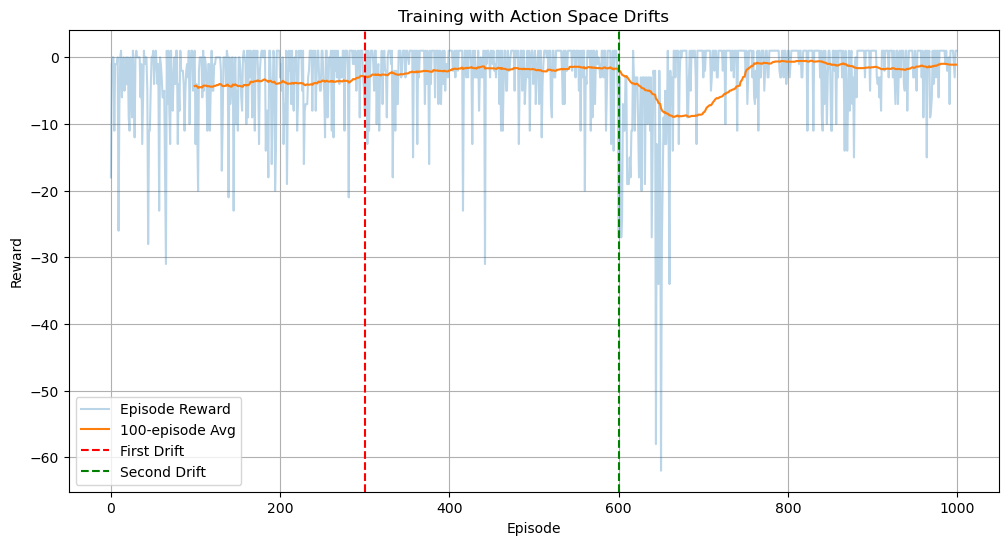


After Episode 300:
Total Actions: 20
Valid Actions: 5
Disabled Actions: ['client afgeleid', 'naar andere kamer/ruimte gestuurd']
Action Mask: [True, True, True, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False]

After Episode 600:
Total Actions: 20
Valid Actions: 7
Disabled Actions: ['client afgeleid', 'naar andere kamer/ruimte gestuurd']
Action Mask: [True, True, True, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False]


In [22]:
# 初始化环境和智能体
env = TaskEnv_actionD(max_actions=20)
state_dim = 5  # 根据你的状态表示调整
agent = MaskedDQNAgent(env, state_dim, lr=1e-3, epsilon_decay=0.998)

# 运行训练
print("=== Starting Training with Drifts ===")
rewards, action_infos,steps = train_with_drifts(env, agent, episodes=1000, drift_episodes=[300, 600])

# 绘制结果
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(rewards, alpha=0.3, label='Episode Reward')
plt.plot(pd.Series(rewards).rolling(100).mean(), label='100-episode Avg')
plt.axvline(x=300, color='r', linestyle='--', label='First Drift')
plt.axvline(x=600, color='g', linestyle='--', label='Second Drift')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training with Action Space Drifts")
plt.legend()
plt.grid()
plt.show()

# 打印drift前后的动作信息
for ep, info in action_infos:
    print(f"\nAfter Episode {ep}:")
    print(f"Total Actions: {info['total_actions']}")
    print(f"Valid Actions: {info['valid_actions']}")
    print(f"Disabled Actions: {info['disabled_action_names']}")
    print(f"Action Mask: {info['action_mask']}")

In [2]:
env = TaskEnv_actionD(max_actions=20) #有问题，max action space 在对应位置action 是non 的情况怎么iterate 在已有的范围内iterate，但是在act的时候不选择被mask掉的action


/Users/veetin/Desktop/drifttest_pa/main/dyna_env_acdy.py:48: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action])


In [7]:
class ValueIterationAgent:
    def __init__(self, env, gamma=0.99, theta=1e-5):
        self.env = env
        self.gamma = gamma
        self.theta = theta
        self.states = env.states  # 假设状态空间固定
        self.actions = env.motions  # 所有可能动作
        self.V = {s: 0.0 for s in self.states}
        self.policy = {s: None for s in self.states}

    def value_iteration(self):
        print('run value iteration')
        while True:
            delta = 0
            for s in self.states:
                if s == 'Tau':  # 终止状态
                    continue
                v = self.V[s]
                q_values=[]
                max_q = float('-inf')
             
                for a in self.actions:
                    if not self.env.get_action_mask()[self.actions.index(a)]:
                        continue  # mask 为 False 的动作不可选
                    q = 0
                    for next_state, prob in self.env.observation_space[s][a].items():
                        #print(self.env.observation_space[s][a].items())
                        reward = self.env.severity.get(next_state, 0)+ self.env.get_action_reward(a)                    
                        if next_state == 'Tau':
                            q+= prob*reward
                        else:
                            q += prob * (reward + self.gamma * self.V[next_state])
                            
                        if q > max_q:
                            max_q = q
                
                    q_values.append(q)
                
                max_q = max(q_values)
                delta = max(delta, abs(self.V[s] - max_q))
                self.V[s] = max_q
                self.policy[s] = np.argmax(q_values)
                
            if delta < self.theta:
                break

    def select_action(self, state):
        return self.policy[state]

In [8]:
agent = ValueIterationAgent(env)

num_episodes = 900
reward_log = []

for episode in range(1, num_episodes + 1):
    # Episode-based action space change
    if episode == 300:
        env.set_flag()
        env.drift(add_actions=-2, 
        drift_type='sudden',
        disable_actions=['client afgeleid', 'naar andere kamer/ruimte gestuurd'])
        agent.value_iteration()
        print(agent.policy)

    if episode == 600:
        env.drift(add_actions=2, drift_type='sudden')
        print(agent.policy)

    # Run Value Iteration and extract policy
    

    # Evaluate one episode following greedy policy
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)

        if action is None:
            break  # No valid action available (e.g. all masked out)

        state, reward, done, info = env.step(action)
        total_reward += reward

    reward_log.append(total_reward)


Disabled actions: ['client afgeleid', 'naar andere kamer/ruimte gestuurd']
run value iteration
{'va': 1, 'sib': 2, 'pp': 1, 'po': 1, 'Tau': None}
Added 2 new actions: ['a0', 'a1']
{'va': 1, 'sib': 2, 'pp': 1, 'po': 1, 'Tau': None}


In [6]:
env.observation_space['pp']['a0']

{'va': 0.0,
 'sib': 0.013346201755036091,
 'pp': 0.4053198048712896,
 'po': 0.2903642681820308,
 'Tau': 0.29096972519164355}

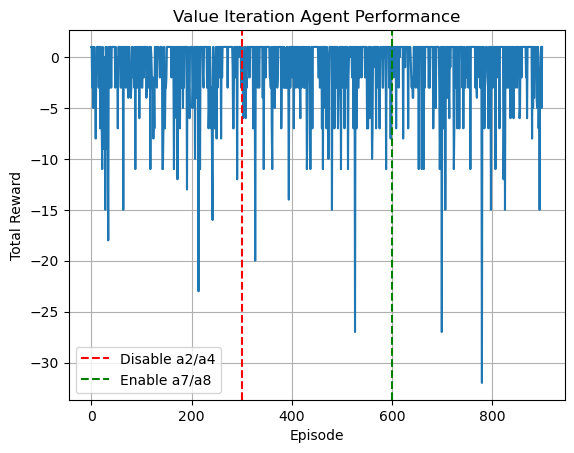

In [16]:
import matplotlib.pyplot as plt

plt.plot(reward_log)
plt.axvline(300, color='red', linestyle='--', label='Disable a2/a4')
plt.axvline(600, color='green', linestyle='--', label='Enable a7/a8')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.title('Value Iteration Agent Performance')
plt.grid(True)
plt.show()

In [13]:
agent = RandomMaskedAgent(env)

num_episodes = 900
reward_log = []

for episode in range(1, num_episodes + 1):
    # Episode-based action space change
    if episode == 300:
        env.set_flag()
        env.drift(add_actions=-2, 
        drift_type='sudden',
        disable_actions=['client afgeleid', 'naar andere kamer/ruimte gestuurd'])

    if episode == 600:
        env.drift(add_actions=2, drift_type='sudden')

    # Run Value Iteration and extract policy
    # Evaluate one episode following greedy policy
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.select_action()
        #print(action)
        if action is None:
            break  # No valid action available (e.g. all masked out)

        state, reward, done, info = env.step(action)
        total_reward += reward
    reward_log.append(total_reward)





{'pp': 0.3647011308562197, 'Tau': 0.4810177705977383, 'va': 0.10379644588045234, 'po': 0.031906300484652664, 'sib': 0.018578352180936994}
{'Tau': 0.3983050847457627, 'pp': 0.2330508474576271, 'va': 0.038135593220338986, 'sib': 0.3220338983050847, 'po': 0.00847457627118644}
{'va': 0.0, 'sib': 0.013346201755036091, 'pp': 0.4053198048712896, 'po': 0.2903642681820308, 'Tau': 0.29096972519164355}
{'Tau': 0.5189873417721519, 'sib': 0.0759493670886076, 'va': 0.08860759493670886, 'pp': 0.21518987341772153, 'po': 0.10126582278481013}
{'Tau': 0.3983050847457627, 'pp': 0.2330508474576271, 'va': 0.038135593220338986, 'sib': 0.3220338983050847, 'po': 0.00847457627118644}
{'Tau': 0.44761199555720105, 'pp': 0.42169566827101074, 'po': 0.025175860792299148, 'va': 0.07071455016660497, 'sib': 0.03480192521288412}
{'Tau': 0.3983050847457627, 'pp': 0.2330508474576271, 'va': 0.038135593220338986, 'sib': 0.3220338983050847, 'po': 0.00847457627118644}
{'pp': 0.21052631578947367, 'Tau': 0.5263157894736842, 'si

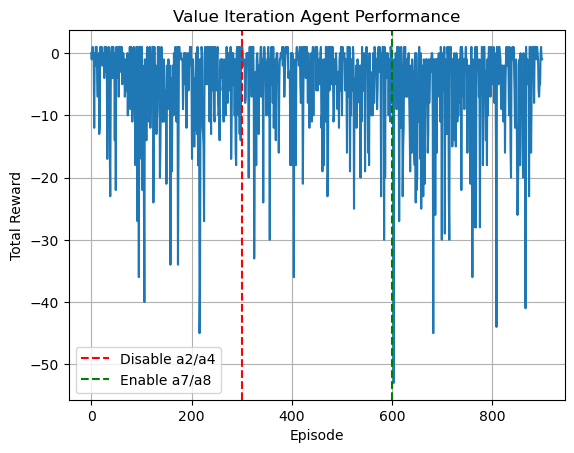

In [14]:
import matplotlib.pyplot as plt

plt.plot(reward_log)
plt.axvline(300, color='red', linestyle='--', label='Disable a2/a4')
plt.axvline(600, color='green', linestyle='--', label='Enable a7/a8')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.title('Value Iteration Agent Performance')
plt.grid(True)
plt.show()

In [ ]:
def run_agent_apply_drift(agent_type,apply_drift=True,add_actions=0, change_at_states=['pp'], drift_dis_type='random',intensity = 0.7,drift_type='sudden'):
    #initial agent
    env = TaskEnv_actionD()
    state_dim = len(env.states) 
    action_dim = len(env.motions)  
    state_to_index = {state: idx for idx, state in enumerate(env.states)}
    agent = None
    
    
    match agent_type:
        case 'Q':
            agent = Q_learning_Agent(env)
        case 'DQN':
            agent = DQNAgent(state_dim,action_dim)
        case 'PPO':
            agent = PPOAgent(state_dim,action_dim)
        case 'Opt':
            agent = OptimalPolicyAgent(env)
            agent.value_iteration()
            for state, action in agent.policy.items():
                print(f"In state {state}, take action: {action}")
        case 'R':
            agent = RandomAgent(env)
        case 'MetaDQN':
            agent = MetaDQNAgent(env)
  
    
    episode_rewards = []
    episode_lengths = []
    episodic_trojactory = []
    information = {}
    """
    if drift_type=='sudden':
        total_episodes = 2000
        drift_episode = 500 #在第500个episode触发drift
    elif drift_type=='gradual':
        total_episodes = 2100
        drift_episode = 700 #在第500个episode触发drift
    """

    update_interval=10  #for PPO

    suffix = f"changestate{change_at_states}_{agent_type}"
    for episode in range(total_episodes):
        steps = 0
        # 应用drift
        if apply_drift and episode == drift_episode:             
            print(f"\n=== Introducing Drift at Episode {episode} ===")
            env.set_flag()  # Enable drift
            
            # Example: Remove 2 actions by disabling them
            if episode == drift_episodes[0]:
                env.drift(add_actions=-2, 
                        drift_type='sudden',
                        disable_actions=['client afgeleid', 'naar andere kamer/ruimte gestuurd'])
                
                print("Action info after drift:")
                print(env.get_action_info())

            if episode == drift_episodes[1]:
                        env.drift(add_actions=2, 
                        drift_type='sudden')
                       # disable_actions=['client afgeleid', 'naar andere kamer/ruimte gestuurd'])
                        print("Action info after drift:")
                        print(env.get_action_info())
   

            
            print(f"Drift applied at episode {episode}")
            if agent_type =='Opt':
                print('reset the optimal oplicy for policy iteration model.')
                agent.value_iteration()
                #print('new optimal policy:')
                for state, action in agent.policy.items():
                    print(f"In state {state}, take action: {action}")
                """    
                suffix = f"{agent_type}_{apply_drift}_{change_at_states}_{drift_dis_type}"
                save_to_csv(agent.policy, f"{suffix}_optpolicy.csv")
                

        if apply_drift and drift_type == 'gradual' and episode == drift_episode+700:
                #swap to another distribution after 100 episode
            env.drift_swap = True
            env.observation_space = env.observation_space_drift.copy(deep=True)
            if agent_type =='Opt':
                print('reset the optimal oplicy for policy iteration model.')
                agent.value_iteration()
        """
                

        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            if agent_type == 'Q':
               # print(agent)
                action = agent.select_action(state)
            elif agent_type in['R','Opt']:
                action = agent.act(state)
            elif agent_type =='DQN':
                action = agent.get_action(state, state_to_index)
            elif agent_type =='PPO':
                action, log_prob, value = agent.select_action(state)
            elif agent_type =='MetaDQN':
                action = agent.act(state)
            
            
            next_state, reward, done, info = env.step(action)
            
            if info != []:
                key = ''.join(str(x) for x in info)
                if key not in information:
                    information[key] = 1
                else:
                    information[key] += 1
            if agent_type == 'Q':
                #print(agentt
                agent.learn(state, action, next_state, reward, done)
            elif agent_type== 'DQN':
                agent.remember(state, action, reward, next_state, done)
                agent.train(batch_size=1, state_to_index=state_to_index)
            elif agent_type =='PPO':
                agent.store_transition(state, action, reward, log_prob, value, done)
            elif agent_type =='MetaDQN':
                agent.remember(state, action, reward, next_state, done)
                # Standard replay
                loss = agent.replay()
                if loss:
                    agent.loss_history.append(loss)
                # Meta-update less frequently
                if episode % 10 == 0:
                    agent.meta_update()
                            # Update target network periodically
                if episode% agent.update_target_every == 0:
                    agent.target_model.load_state_dict(agent.model.state_dict())
                # Decay epsilon
                if agent.epsilon > agent.epsilon_min:
                    agent.epsilon *= agent.epsilon_decay
                  
            state = next_state
            episode_reward += reward
            steps +=1
        if agent_type=='PPO':
            if (episode + 1) % update_interval == 0:
                agent.update()
                agent.clear_memory()
            
        episodic_trojactory.append(info)
        episode_lengths.append(steps)
        episode_rewards.append(episode_reward)
    
    return episode_rewards, episode_lengths,information,episodic_trojactory



def run_agent_avg(agent_type, apply_drift=True, add_actions=0, 
                  change_at_states=['pp','po','va','sib'], 
                  drift_dis_type='similar', intensity=0.7, drift_type='sudden'):
    
    num_runs = 5
    all_rewards = []
    all_lengths = []
    info_first_run = None

    for run in range(num_runs):
        rewards, lengths, info, trojactory= run_agent_apply_drift(
            agent_type=agent_type,
            apply_drift=apply_drift,
            add_actions=add_actions,
            change_at_states=change_at_states,
            drift_dis_type=drift_dis_type,
            intensity=intensity,
            drift_type=drift_type
        )
        all_rewards.append(rewards)
        all_lengths.append(lengths)
        if run == 0:
            info_first_run = info
            trojactory_first_run = trojactory

    # Convert to numpy arrays for averaging
    all_rewards = np.array(all_rewards)
    all_lengths = np.array(all_lengths)

    avg_rewards = np.mean(all_rewards, axis=0).tolist()
    avg_lengths = np.mean(all_lengths, axis=0).tolist()

    sd_rewards = np.std(all_rewards, axis=0).tolist()
    sd_lengths = np.std(all_lengths, axis=0).tolist()

    return avg_rewards, avg_lengths, sd_rewards, sd_lengths #info_first_run,trojactory_first_run